# Paper Figures: Figure 3 - Cluster Analysis

This notebook generates publication-ready figures for cluster analysis of dopamine responses using data assembled by `src/assemble_all_data.py`.

**Figure 3: Cluster Analysis** — Pie charts showing cluster composition, representative heatmaps by rat, and summary cluster responses with statistical analysis.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import dill
from scipy import stats

# Add src to path for importing local modules
sys.path.insert(0, str(Path("../src").resolve()))

from figure_config import (
    configure_matplotlib, COLORS, HEATMAP_CMAP,
    DATAFOLDER, RESULTSFOLDER, FIGSFOLDER,
    SAVE_FIGS
)
from figure_plotting import (
    save_figure
)

# Configure matplotlib
configure_matplotlib()
colors = COLORS  # Use shared color palette
custom_cmap = HEATMAP_CMAP  # Use shared colormap

## Load Assembled Data

Load the complete dataset from the pickle file generated by the assembly script.

In [2]:
assembled_data_path = DATAFOLDER / "assembled_data.pickle"

with open(assembled_data_path, "rb") as f:
    data = dill.load(f)

# Extract main components
x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_behav = data["snips_behav"]
fits_df = data["fits_df"]

print(f"Loaded assembled data from {assembled_data_path}")
print(f"\nData structure:")
print(f"  - x_array shape: {x_array.shape}")
print(f"  - snips_photo shape: {snips_photo.shape}")
print(f"  - x_array columns: {x_array.columns.tolist()}")
print(f"  - Number of trials: {len(x_array)}")

Loaded assembled data from ..\data\assembled_data.pickle

Data structure:
  - x_array shape: (1960, 11)
  - snips_photo shape: (1960, 200)
  - x_array columns: ['trial', 'id', 'condition', 'infusiontype', 'sex', 'cluster_photo', 'clusterness_photo', 'euclidean_diff', 'auc_snips', 'auc_vel', 'time_moving']
  - Number of trials: 1960


## Figure 3: Cluster Analysis — Dopamine Response Clustering

Analysis of dopamine neuron clustering during sodium appetite showing pie charts of cluster composition, representative individual heatmaps, aggregate cluster heatmaps, and time series summaries.

In [3]:
# Identify clusters in the data
n_clusters = len(x_array.cluster_photo.unique())
print(f"Number of clusters found: {n_clusters}")
print(f"Cluster labels: {sorted(x_array.cluster_photo.unique())}")

# Verify data has cluster information
print(f"\nCluster distribution:")
print(x_array['cluster_photo'].value_counts().sort_index())

Number of clusters found: 2
Cluster labels: [np.int64(0), np.int64(1)]

Cluster distribution:
cluster_photo
0     624
1    1336
Name: count, dtype: int64


### 3A. Pie Charts — Cluster Composition by Condition

Cluster 0: n=624, Chi-squared p-value: 0.0000
Cluster 1: n=1336, Chi-squared p-value: 0.0000


C:\Users\jmc010\AppData\Local\Temp\ipykernel_32004\1458969196.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


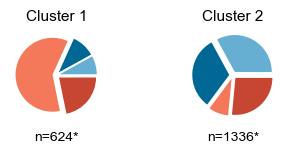


Overall Chi-squared Test for Independence:
Chi2 Statistic: 635.9542, P-value: 0.0000, DOF: 3


In [4]:
# Create pie charts for cluster composition across conditions
f, ax = plt.subplots(ncols=n_clusters, figsize=(1.8*n_clusters, 1.2),
                     gridspec_kw={'left': 0.05, 'right': 0.95})

if n_clusters == 1:
    ax = [ax]  # Make iterable for consistency

all_clusters_observed_counts = []

for cluster_idx, cluster in enumerate(sorted(x_array.cluster_photo.unique())):
    tmp = x_array.query("cluster_photo == @cluster")
    total = len(tmp)
    
    observed_counts = [
        len(tmp.query("condition == 'replete' & infusiontype == '10NaCl'")),
        len(tmp.query("condition == 'replete' & infusiontype == '45NaCl'")),
        len(tmp.query("condition == 'deplete' & infusiontype == '10NaCl'")),
        len(tmp.query("condition == 'deplete' & infusiontype == '45NaCl'"))
    ]
    all_clusters_observed_counts.append(observed_counts)
    
    pie_props = [count / total if total > 0 else 0 for count in observed_counts]
    
    if total > 0:
        expected_counts = [total / 4, total / 4, total / 4, total / 4]
        chi2_stat, p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)
        print(f"Cluster {cluster}: n={total}, Chi-squared p-value: {p_value:.4f}")
        significance_marker = "*" if p_value < 0.05 else ""
    else:
        significance_marker = ""
    
    ax[cluster_idx].pie(pie_props,
                  colors=colors,
                  explode=(0.1, 0.1, 0.1, 0.1),
                  )
    
    ax[cluster_idx].text(0, -1.7, f"n={total}{significance_marker}", ha="center", va="center", fontsize=10, color="k")
    ax[cluster_idx].set_title(f"Cluster {cluster_idx+1}", fontsize=11)

plt.tight_layout()
if SAVE_FIGS:
    save_figure(f, "fig3a_pie_clusters", FIGSFOLDER)
plt.show()

# Save contingency table
contingency_table = np.array(all_clusters_observed_counts)
np.savetxt(RESULTSFOLDER / "cluster_contingency_table.csv", contingency_table, delimiter=",", fmt='%d')

# Overall Chi-squared test
if contingency_table.sum() > 0 and not (np.any(contingency_table.sum(axis=1) == 0) or np.any(contingency_table.sum(axis=0) == 0)):
    chi2_overall, p_overall, dof_overall, expected_freq_overall = stats.chi2_contingency(contingency_table)
    print("\nOverall Chi-squared Test for Independence:")
    print(f"Chi2 Statistic: {chi2_overall:.4f}, P-value: {p_overall:.4f}, DOF: {dof_overall}")

### 3B. Legend Patches — Condition Colors

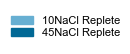

In [5]:
# Legend for replete conditions
f, ax = plt.subplots(figsize=(0.35, 0.45), gridspec_kw={'left': 0.01, 'right': 0.99})

legend_patches = []
legend_labels = ["10NaCl Replete", "45NaCl Replete"]
for color, label in zip(colors[:2], legend_labels):
    patch = Patch(color=color, label=label)
    legend_patches.append(patch)

ax.legend(handles=legend_patches, loc='center', fontsize=8, frameon=False,
          labelspacing=0.2, borderpad=0.05)
ax.axis('off')

if SAVE_FIGS:
    save_figure(f, "fig3b_legend_replete", FIGSFOLDER)
plt.show()

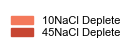

In [6]:
# Legend for deplete conditions
f, ax = plt.subplots(figsize=(0.35, 0.45), gridspec_kw={'left': 0.01, 'right': 0.99})

legend_patches = []
legend_labels = ["10NaCl Deplete", "45NaCl Deplete"]
for color, label in zip(colors[2:], legend_labels):
    patch = Patch(color=color, label=label)
    legend_patches.append(patch)

ax.legend(handles=legend_patches, loc='center', fontsize=8, frameon=False,
          labelspacing=0.2, borderpad=0.05)
ax.axis('off')

if SAVE_FIGS:
    save_figure(f, "fig3b_legend_deplete", FIGSFOLDER)
plt.show()

### 3C. Heatmap — Clustered Dopamine Responses

Cluster 0
  Shape: (624, 200)
Cluster 1
  Shape: (1336, 200)


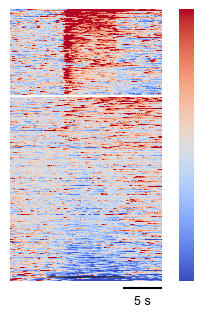

In [7]:
# Create clustered heatmap sorted by response strength within each cluster
list_of_clustered_snips = []
n_of_clusters_list = []

for cluster in sorted(x_array.cluster_photo.unique()):
    print(f"Cluster {cluster}")
    tmp = snips_photo[x_array.cluster_photo == cluster, :]
    # Sort by mean response during infusion window
    sort_order = np.argsort(np.mean(tmp[:, 50:150], axis=1))[::-1]
    snips_cluster = tmp[sort_order, :]
    
    print(f"  Shape: {snips_cluster.shape}")
    list_of_clustered_snips.append(snips_cluster)
    n_of_clusters_list.append(snips_cluster.shape[0])

clustered_snips = np.vstack(list_of_clustered_snips)

# Create heatmap with cluster dividing lines
layout = [["ax", "cbar_ax"],
          ["ax", "empty"]]

f = plt.figure(figsize=(2.3, 3.6))
gs = f.add_gridspec(2, 2, width_ratios=[10, 1], height_ratios=[1, 0.01],
                     left=0.1, right=0.9, wspace=0.2, hspace=0.02)

ax = f.add_subplot(gs[0, 0])
cbar_ax = f.add_subplot(gs[0, 1])

sns.heatmap(clustered_snips, ax=ax, vmin=-2, vmax=2, cmap="coolwarm", cbar_ax=cbar_ax)
ax.set_yticks([])
ax.set_xticks([])

# Draw cluster dividing lines
for c in np.cumsum(n_of_clusters_list)[:-1]:
    ax.axhline(c, color="white", linewidth=1.5)

# Add time scale bar
ax.plot([150, 198], [len(clustered_snips)+50, len(clustered_snips)+50], color="k", linewidth=1.5, clip_on=False)
ax.text(174, len(clustered_snips)+100, "5 s", ha="center", va="top", fontsize=9)

# Infusion window indicator
ax.plot([50, 150], [len(clustered_snips)-30, len(clustered_snips)-30], color="k", alpha=0.5, linewidth=1.5, clip_on=False)

cbar_ax.set_yticks([])

if SAVE_FIGS:
    save_figure(f, "fig3c_heatmap_clusters", FIGSFOLDER)
plt.show()

### 3D. Line Plots — Cluster Response Summary

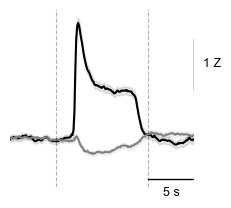

In [8]:
# Create summary line plots for each cluster
cluster_colors = ["black", "grey"]

f, ax = plt.subplots(figsize=(2.3, 2.3), gridspec_kw={'left': 0.1, 'right': 0.9})

for cluster_idx, cluster in enumerate(sorted(x_array.cluster_photo.unique())):
    color = cluster_colors[cluster_idx] if cluster_idx < len(cluster_colors) else "black"
    
    snips_cluster = snips_photo[x_array.cluster_photo == cluster, :]
    x = np.arange(snips_cluster.shape[1]) / 10  # Convert to seconds
    mean = np.mean(snips_cluster, axis=0)
    sd = np.std(snips_cluster, axis=0)
    sem = sd / np.sqrt(snips_cluster.shape[0])
    ci = sem * 1.96
    
    ax.plot(x, mean, color=color, lw=1.5, label=f"Cluster {cluster_idx+1} (n={snips_cluster.shape[0]})")
    ax.fill_between(x, mean-ci, mean+ci, alpha=0.1, color=color)

ax.set_xlim(0, 20)
ax.axvline(5, color="k", linestyle="--", alpha=0.3, linewidth=0.8)
ax.axvline(15, color="k", linestyle="--", alpha=0.3, linewidth=0.8)
ax.set_xticks([])
ax.set_yticks([])
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)

# Add scale bars
ax.plot([20, 20], [1, 2], color="k", linewidth=1)
ax.text(21, 1.5, "1 Z", ha="left", va="center", fontsize=9)

ax.plot([15, 20], [-0.8, -0.8], color="k", linewidth=1)
ax.text(17.5, -0.95, "5 s", ha="center", va="top", fontsize=9)

if SAVE_FIGS:
    save_figure(f, "fig3d_line_clusters", FIGSFOLDER)
plt.show()

### 3E. Representative Heatmaps — Individual Animal Responses

Exemplary animals for figure: ['PB23', 'PB24', 'PB26', 'PB27']


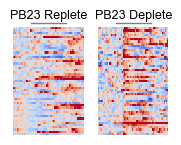

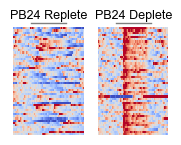

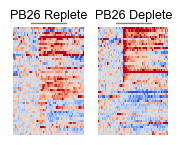

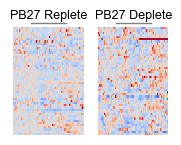

In [9]:
# Select exemplary animals for each cluster
vlim = 2

# Find animals with most trials for representation
animal_trial_counts = x_array.groupby('id').size().sort_values(ascending=False)
exemplary_animals = animal_trial_counts.head(4).index.tolist()  # Get top 4 animals

print(f"Exemplary animals for figure: {exemplary_animals}")

for animal_id in exemplary_animals:
    animal_data = x_array[x_array.id == animal_id]
    
    f, ax = plt.subplots(ncols=2, figsize=(2, 1.4))
    
    replete_data = snips_photo[(x_array.id == animal_id) & (x_array.condition == "replete"), :]
    deplete_data = snips_photo[(x_array.id == animal_id) & (x_array.condition == "deplete"), :]
    
    if len(replete_data) > 0:
        sns.heatmap(data=replete_data, vmin=-vlim, vmax=vlim, ax=ax[0], cmap="coolwarm", cbar=False)
        ax[0].set_title(f"{animal_id} Replete", fontsize=9)
    
    if len(deplete_data) > 0:
        sns.heatmap(data=deplete_data, vmin=-vlim, vmax=vlim, ax=ax[1], cmap="coolwarm", cbar=False)
        ax[1].set_title(f"{animal_id} Deplete", fontsize=9)
    
    for axis in ax:
        axis.set_yticks([])
        axis.set_xticks([])
        axis.plot([50, 150], [-2, -2], color="k", alpha=0.5, linewidth=1, clip_on=False)
    
    if SAVE_FIGS:
        save_figure(f, f"fig3e_heatmap_representative_{animal_id}", FIGSFOLDER)
    
    plt.show()

## Organization Notes

This notebook generates Figure 3 components from the cluster analysis:
- **3A**: Pie charts showing the distribution of trials across conditions within each cluster
- **3B**: Legend patches for color identification
- **3C**: Heatmap of all trials organized by cluster, sorted by response magnitude
- **3D**: Summary line plots showing mean response ± 95% CI for each cluster
- **3E**: Representative individual animal heatmaps showing replete vs deplete responses

Set `SAVE_FIGS=True` in `figure_config.py` to export figures as PDF and PNG.

In [10]:
print(f"Figure export status: SAVE_FIGS = {SAVE_FIGS}")
print(f"Output folder: {FIGSFOLDER}")
print(f"\nFigure 3 generation complete!")

Figure export status: SAVE_FIGS = False
Output folder: ..\paper\figs

Figure 3 generation complete!
